In [1]:
import torch
import os

# Verificar GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)


Usando dispositivo: cuda


In [2]:
import os
from PIL import Image
import numpy as np


def process_transparent_mask(mask_path):
    """
    Convierte una máscara RGB con transparencia a una máscara binaria (blanco y negro).
    Args:
        mask_path (str): Ruta a la máscara RGB con transparencia.
    Returns:
        np.array: Máscara binaria.
    """
    # Cargar la máscara en modo RGBA para incluir el canal alfa
    mask = Image.open(mask_path).convert("RGBA")
    mask_np = np.array(mask)

    # Extraer el canal alfa
    alpha_channel = mask_np[:, :, 3]

    # Binarizar el canal alfa (0: fondo, 255: mano)
    binary_mask = (alpha_channel > 127).astype(np.uint8) * 255

    return binary_mask


def preprocess_transparent_masks(input_dir, output_dir):
    """
    Preprocesa máscaras RGB con transparencia y las convierte en máscaras binarias.
    Args:
        input_dir (str): Directorio con máscaras originales (RGB con transparencia).
        output_dir (str): Directorio donde se guardarán las máscaras binarias.
    """
    os.makedirs(output_dir, exist_ok=True)

    for mask_name in os.listdir(input_dir):
        mask_path = os.path.join(input_dir, mask_name)

        if mask_name.endswith(('.png', '.jpg', '.jpeg')):
            binary_mask = process_transparent_mask(mask_path)

            # Guardar la máscara binaria como PNG
            output_path = os.path.join(output_dir, mask_name)
            Image.fromarray(binary_mask).save(output_path)
            print(f"Procesada y guardada: {output_path}")


# Directorios para train, val y test
data_dirs = {
    "train": {
        "input": "../data/train/masks",
        "output": "../data/train/cleaned_masks"
    },
    "val": {
        "input": "../data/val/masks",
        "output": "../data/val/cleaned_masks"
    },
    "test": {
        "input": "../data/test/masks",
        "output": "../data/test/cleaned_masks"
    }
}

# Procesar máscaras de todos los conjuntos
for dataset, dirs in data_dirs.items():
    print(f"Preprocesando máscaras de {dataset}...")
    preprocess_transparent_masks(dirs["input"], dirs["output"])
    print(f"Máscaras de {dataset} procesadas y guardadas en {dirs['output']}\n")


In [3]:
import os
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Definir las transformaciones para imágenes y máscaras
class SegmentationTransform:
    def __init__(self, input_size):
        self.image_transform = transforms.Compose([
            transforms.Resize((input_size, input_size)),  # Redimensionar a tamaño fijo
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],  # Normalización para imágenes preentrenadas
                                 [0.229, 0.224, 0.225])  # Convertir a tensor
        ])
        self.mask_transform = transforms.Compose([
            transforms.Resize((input_size, input_size)),  # Redimensionar máscaras
            transforms.ToTensor()  # Convertir a tensor
        ])

    def __call__(self, image, mask):
        image = self.image_transform(image)
        mask = self.mask_transform(mask)
        return image, mask

# Dataset personalizado para segmentación
class HandSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(('.png', '.jpg'))])
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir, self.image_files[idx].replace('_image', '_mask').rsplit(".", 1)[0] + ".png")

        # Cargar imagen y máscara
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Escala de grises

        # Aplicar transformaciones
        if self.transform:
            image, mask = self.transform(image, mask)

        # Binarizar máscara a [0,1]
        mask = (mask > 0.5).float()

        return image, mask

datasets = {
    'train': HandSegmentationDataset(
        images_dir="../data/train/images",
        masks_dir="../data/train/cleaned_masks",  # Rutas actualizadas
        transform=SegmentationTransform(input_size=512)  # Transformaciones de Torch
    ),
    'val': HandSegmentationDataset(
        images_dir="../data/val/images",
        masks_dir="../data/val/cleaned_masks",  # Rutas actualizadas
        transform=SegmentationTransform(input_size=512)
    ),
    'test': HandSegmentationDataset(
        images_dir="../data/test/images",
        masks_dir="../data/test/cleaned_masks",  # Rutas actualizadas
        transform=SegmentationTransform(input_size=512)
    )
}

batch_size = 4
dataloaders = {
    x: DataLoader(
        datasets[x],
        batch_size=batch_size,
        shuffle=(x == 'train'),
    )
    for x in ['train', 'val', 'test']
}


In [9]:
# Celda: Definición del modelo U-Net con ResNet50
import segmentation_models_pytorch as smp

# Modelo U-Net con ResNet50 como backbone
model = smp.Unet(
    encoder_name="resnet50",       # Encoder
    encoder_weights="imagenet",   # Pesos preentrenados en ImageNet
    in_channels=3,                # 3 canales de entrada (RGB)
    classes=1,                    # Salida binaria (1 canal para segmentación)
    activation=None               # Sin activación final, usamos logits
).to(device)

# Definir la función de pérdida y el optimizador
loss_fn = torch.nn.BCEWithLogitsLoss()  # Para problemas binarios, logits más estables
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Optimización con Adam


In [10]:
# Calcular la accuracy
def calculate_accuracy(preds, masks):
    """
    Calcula la accuracy para segmentación binaria.
    Args:
        preds: Tensor de predicciones (logits o probabilidades binarizadas).
        masks: Tensor de máscaras reales.
    Returns:
        float: Accuracy en el batch.
    """
    preds = (torch.sigmoid(preds) > 0.5).float()  # Binarizar predicciones
    correct = (preds == masks).sum().item()      # Píxeles correctamente clasificados
    total = torch.numel(preds)                   # Total de píxeles
    return correct / total

def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        # Forward
        logits = model(images)
        loss = loss_fn(logits, masks)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calcular loss y accuracy
        running_loss += loss.item()
        running_acc += calculate_accuracy(logits, masks)

    return running_loss / len(dataloader), running_acc / len(dataloader)

@torch.no_grad()
def validate_one_epoch(model, dataloader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0

    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        # Forward
        logits = model(images)
        loss = loss_fn(logits, masks)

        # Calcular loss y accuracy
        running_loss += loss.item()
        running_acc += calculate_accuracy(logits, masks)

    return running_loss / len(dataloader), running_acc / len(dataloader)


In [11]:
# Celda: Bucle principal de entrenamiento
# Parámetros de entrenamiento
num_epochs = 20
patience = 5  # Número de épocas sin mejora antes de detener el entrenamiento
early_stop_counter = 0
best_val_loss = float("inf")
best_model_path = "../data/model/best_model_resnet50.pth"
os.makedirs(os.path.dirname(best_model_path), exist_ok=True)

# Entrenamiento con early stopping
for epoch in range(num_epochs):
    # Entrenamiento
    train_loss, train_acc = train_one_epoch(model, dataloaders['train'], optimizer, loss_fn, device)

    # Validación
    val_loss, val_acc = validate_one_epoch(model, dataloaders['val'], loss_fn, device)

    # Imprimir métricas
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    # Guardar el mejor modelo
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"  --> Guardado mejor modelo con Val Loss: {best_val_loss:.4f}")
        early_stop_counter = 0  # Reiniciar el contador de paciencia
    else:
        early_stop_counter += 1  # Incrementar el contador

    # Detener si no mejora por 'patience' épocas
    if early_stop_counter >= patience:
        print(f"Early stopping activado. No hubo mejora en {patience} épocas consecutivas.")
        break


Epoch [1/20]
  Train Loss: 0.3642, Train Accuracy: 0.8599
  Val Loss: 0.2562, Val Accuracy: 0.9124
  --> Guardado mejor modelo con Val Loss: 0.2562
Epoch [2/20]
  Train Loss: 0.1830, Train Accuracy: 0.9406
  Val Loss: 0.2102, Val Accuracy: 0.9190
  --> Guardado mejor modelo con Val Loss: 0.2102
Epoch [3/20]
  Train Loss: 0.1516, Train Accuracy: 0.9449
  Val Loss: 0.1924, Val Accuracy: 0.9285
  --> Guardado mejor modelo con Val Loss: 0.1924
Epoch [4/20]
  Train Loss: 0.1236, Train Accuracy: 0.9543
  Val Loss: 0.1538, Val Accuracy: 0.9430
  --> Guardado mejor modelo con Val Loss: 0.1538
Epoch [5/20]
  Train Loss: 0.1281, Train Accuracy: 0.9487
  Val Loss: 0.9123, Val Accuracy: 0.8381
Epoch [6/20]
  Train Loss: 0.1257, Train Accuracy: 0.9520
  Val Loss: 0.1510, Val Accuracy: 0.9397
  --> Guardado mejor modelo con Val Loss: 0.1510
Epoch [7/20]
  Train Loss: 0.1183, Train Accuracy: 0.9508
  Val Loss: 0.2166, Val Accuracy: 0.8950
Epoch [8/20]
  Train Loss: 0.0982, Train Accuracy: 0.9616
  Va

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.007843137..1.0296907].


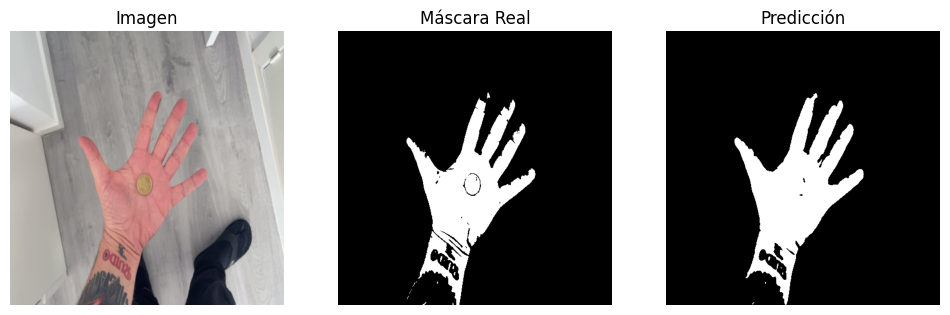

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].


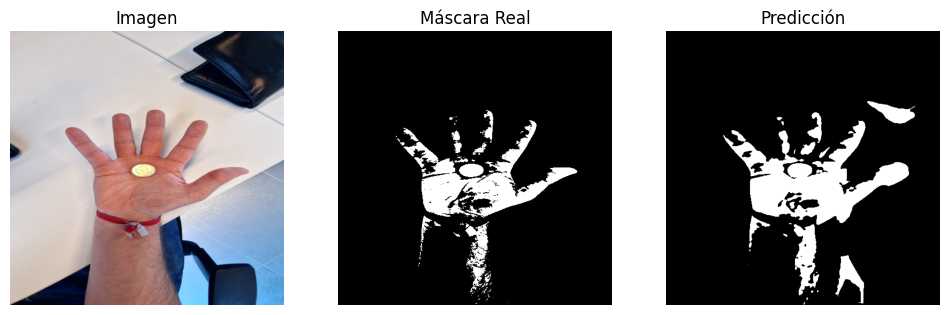

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].


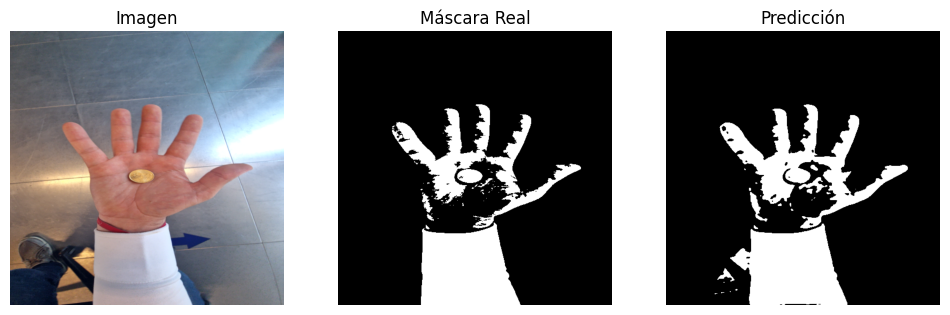

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].


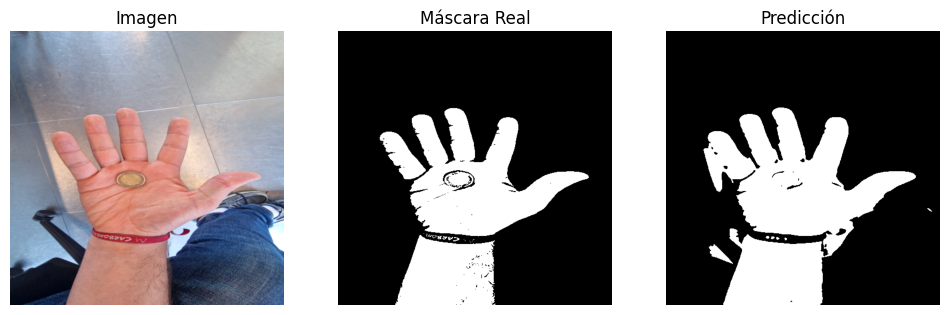

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.018821478..1.0536385].


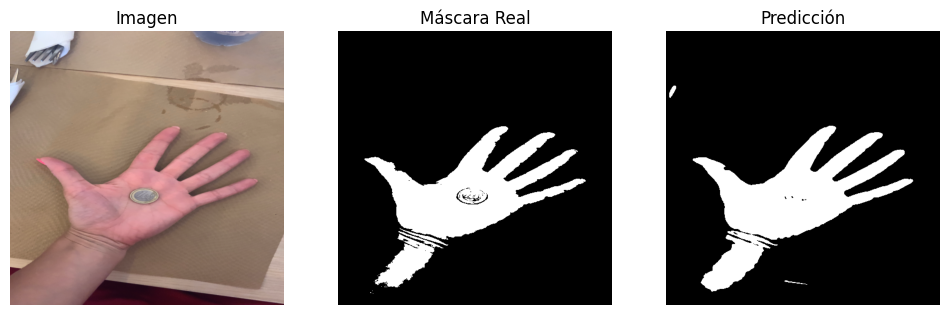

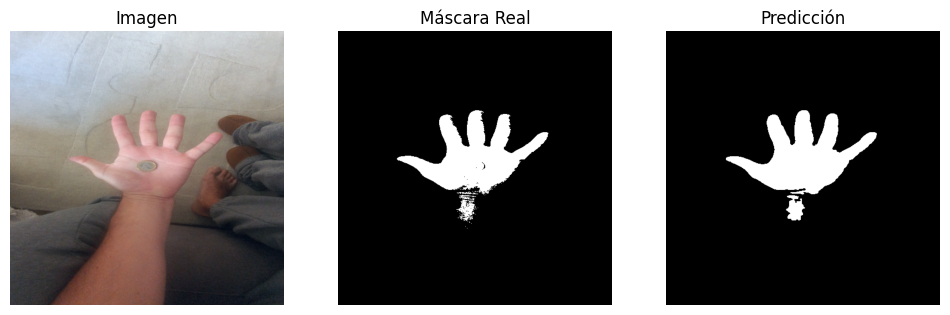

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.082352936..1.0256994].


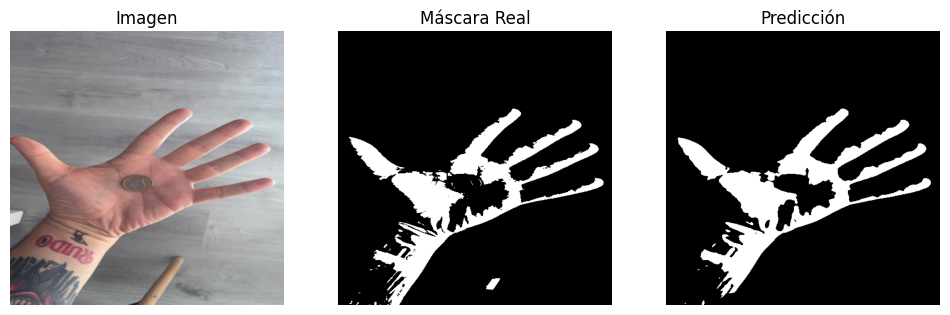

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.043137252..1.08956].


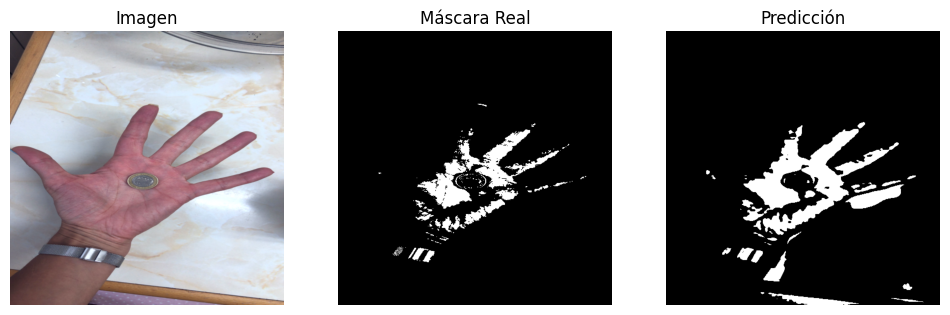

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0855688].


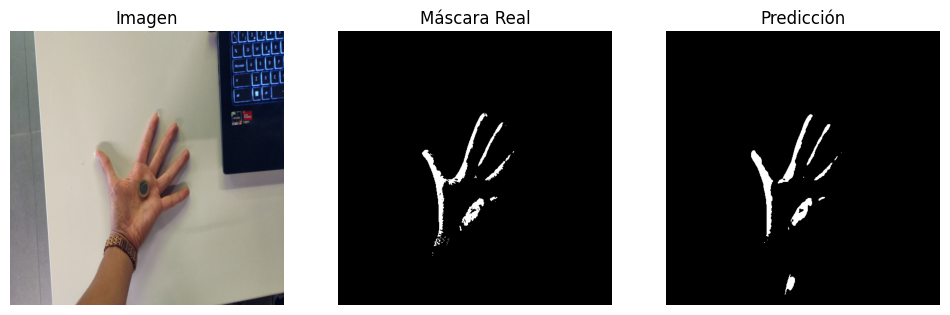

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.019607842..1.08956].


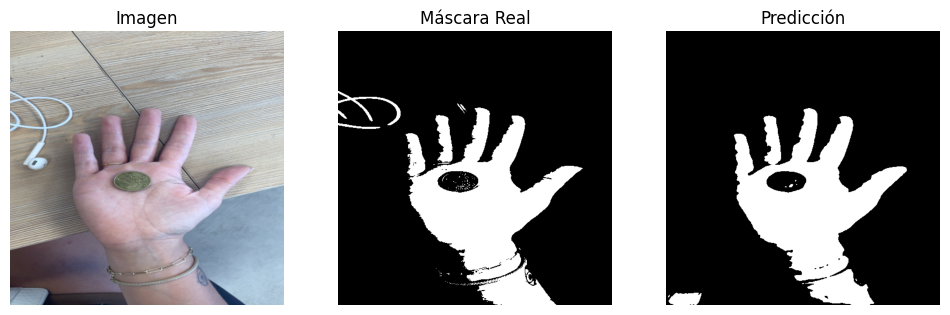

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0855688].


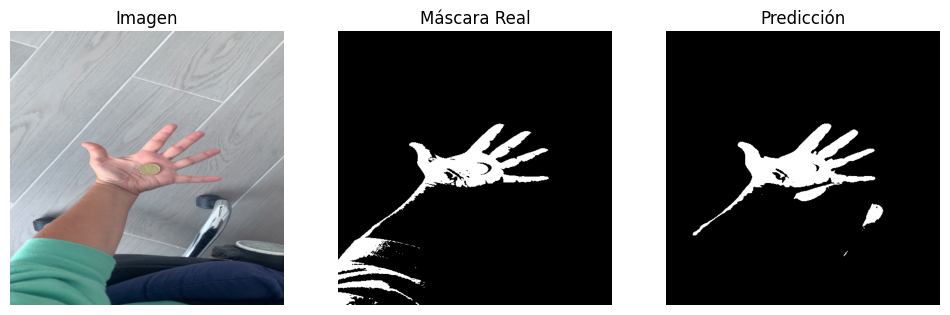

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.041143].


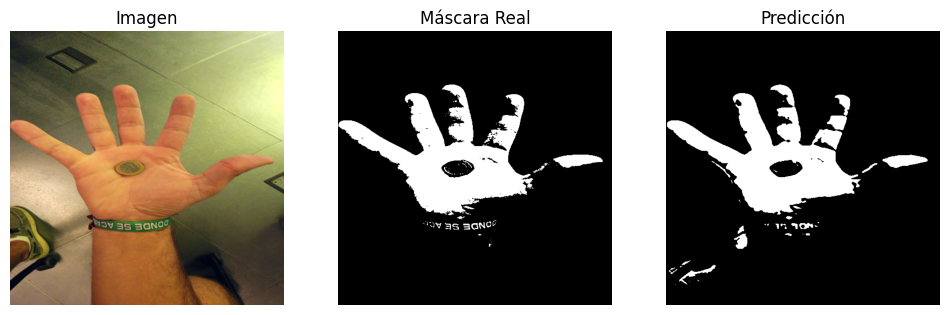

In [12]:
# Celda: Visualización de predicciones
import matplotlib.pyplot as plt

@torch.no_grad()
def visualize_predictions(model, dataloader, device, num_samples=3):
    """
    Visualiza predicciones del modelo junto con las máscaras reales.
    """
    model.eval()
    for i, (images, masks) in enumerate(dataloader):
        if i >= num_samples:
            break

        # Mover a dispositivo
        images, masks = images.to(device), masks.to(device)

        # Predicciones
        logits = model(images)
        preds = torch.sigmoid(logits)  # Convertir logits a probabilidades [0,1]
        preds = (preds > 0.5).float()  # Binarizar predicciones

        # Convertir tensores a CPU y numpy
        images = images.cpu().permute(0, 2, 3, 1).numpy()
        masks = masks.cpu().squeeze(1).numpy()
        preds = preds.cpu().squeeze(1).numpy()

        # Visualizar
        for j in range(images.shape[0]):
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow((images[j] * 0.229 + 0.485))  # Desnormalizar imagen
            plt.title("Original image")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(masks[j], cmap="gray")
            plt.title("Original mask")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(preds[j], cmap="gray")
            plt.title("Predicction mask")
            plt.axis("off")

            plt.show()

# Visualizar 3 predicciones en el conjunto de validación
visualize_predictions(model, dataloaders['test'], device, num_samples=3)